# Exercise 2.1 - Train and Explore Word Vectors

# Working with word vectors
What's the NBA of baseball? One way to answer this is to form an analogy: basketball is to NBA as baseball is to ... ? The answer is MLB (Major League Baseball). One of the more interested developments in the past decade for NLP has been new methods for learning word vectors that encode both the meaning of words _and_ relational knowledge to solve these kinds of analogy tests. In this notebook, you'll see how these work for yourself!

The homework is broken up in several steps of preprocessing code (a constant fact of life for NLP), training a [word2vec](https://en.wikipedia.org/wiki/Word2vec) model using the [gensim](https://radimrehurek.com/gensim_3.8.3/models/word2vec.html) library and then exploring what the vectors have learned. For this notebook, you'll only train on a small set of the data to keep it quick (though this still learns a lot, as you'll see!); we've pre-computed a word2vec model for you on the full data as well, which you will use later in your evaluations. If you want to read up a bit more on word2vec, there's many great [blog](https://israelg99.github.io/2017-03-23-Word2Vec-Explained/) [posts](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) and you could check out the [original paper](https://arxiv.org/pdf/1301.3781.pdf)

This notebook will show you how to train your own vectors in the future too. Methods that learn distributional word vectors (like word2vec, LSA, or even counting) depend on the corpus they're trained on. Here, we're using our list of Wikipedia biographies. This corpus is quite rich in people, places, occupations, and all the things that people do. What all might a model learn from this? You'll see some of it in the tests we have prepared for you, but the model will know a lot more than what we've shown. Once you finish the core tasks, in your own exploration see what else the model has learned. Are there new types of analogies it encodes?

As usual in NLP, there are many options and hyperparameters to choose for word2vec. We've chosen a few to show you here (e.g., tokenization options) to help you get started exploring the space. You can try training on more data, adjust the window size, or the minimum token frequency to see how these impact performance and what the model learns. If you discover something interesting, feel free to discuss!

Finally, if you're feeling ambitious, try plotting pairs of words that have the same relationship, e.g., "NBA", "basketball", "MLB" and "baseball" and see if they have a geometric  relationship. As an example of this type of plot, see the plots for the word2vec alternative [glove](https://nlp.stanford.edu/projects/glove/) that also encodes this type of information. For plotting, try showing the first two principle components of the vectors (you'll first need to run PCA) or use [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). If you make any interesting plots or discover something cool, please feel free to share in Slack!

In [2]:
import gensim
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import pandas as pd
from tqdm.notebook import tqdm
from gensim.models.word2vec import Word2Vec
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.test.utils import datapath

In [3]:
RANDOM_SEED = 655

To reduce the burden on memory, we use only the first 10,000 biographies and save them into a list that we'll call `bios`. We've pre-saved them as a pickle object `bios.p` so that you can load it directly.

In [4]:
bios = []
with open('assets/bios.p', 'rb') as f:
    bios = pickle.load(f)

Use nltk `word_tokenize` to split the biographies in `bios` into words and each bio's words as a separate list into a list called `nltk_tokenized_bios`. Try wrapping these in a `tqdm` call to see how long it takes

In [5]:
# YOUR CODE HERE
nltk_tokenized_bios =[]
for bio in tqdm(bios): 
    tokens_per_bio = word_tokenize(bio)
    nltk_tokenized_bios.append(tokens_per_bio)

#raise NotImplementedError()

Let's compare NLTK's tokenization with a regular expression-based extraction. Write a regular expression to find all sequences of word characters (`\w+`) for each biography in `bios` into words and each bio's words as a separate list into a list called `re_tokenized_bios`. Try wrapping these in a `tqdm` call to see how long it takes. 

In [17]:
# YOUR CODE HERE
re_tokenized_bios=[]

for bio in tqdm(bios):
    tokens_in_bio = re.findall(r'\w+',bio)
    re_tokenized_bios.append(tokens_in_bio)

#raise NotImplementedError()

In [26]:
len(re_tokenized_bios)

10000

A surprising speed difference! Let's count how many unique tokens we found from each. Use a `Counter` to count the number of unique words for each and call these `nltk_word_counts` and `re_word_counts` 

In [20]:
nltk_word_counts = Counter([word for sublist in nltk_tokenized_bios for word in sublist])
re_word_counts   = Counter([word for sublist in re_tokenized_bios for word in sublist])

In [21]:
len(nltk_word_counts), len(re_word_counts)

(294549, 219293)

In [22]:
#hidden tests are within this cell

Let's see what common words we missed through the imprecise regex matching. Create another `Counter` that contains the counts of all words not in `re_word_counts` but `nltk_word_counts` and call this `unique_word_counts`

HINT: familiarize with how to use “Counter” from collections. 
Documentation: https://docs.python.org/3/library/collections.html

In [25]:
# YOUR CODE HERE
import copy
unique_word_counts=nltk_word_counts.copy()
for word in set(re_word_counts.elements()):
    del unique_word_counts[word]

#raise NotImplementedError()

Print what are the 20 most common NLTK-unique words

In [27]:
# YOUR CODE HERE
unique_word_counts.most_common(20)
#raise NotImplementedError()

[(',', 887165),
 ('.', 582162),
 ("''", 248064),
 ('``', 236619),
 ("'s", 138914),
 (')', 93269),
 ('(', 93204),
 (':', 28415),
 (';', 26840),
 ("'", 20367),
 ('===', 9769),
 ('–', 7365),
 ('$', 5738),
 ('...', 5621),
 ("n't", 5528),
 ('*', 4844),
 ('&', 3940),
 ('!', 3296),
 ('U.S.', 3165),
 ('St.', 2727)]

In [115]:
len(unique_word_counts)

81881

In [116]:
#hidden tests are within this cell

Interesting! Looks like we're mostly missing punctuation and a few abbreviations. In this case, we can probably get away with tokenizing with just a regex without missing too much. 

For simplicitly, let's treat the regex-based token as our final solution and label this as a list called `all_tokenized_bios` and call the `re_word_counts` as just `word_counts`

In [25]:
all_tokenized_bios = re_tokenized_bios 
word_counts = re_word_counts

In [118]:
len(word_counts)

219293

In [29]:
len(all_tokenized_bios)

10000

In [119]:
#hidden tests are within this cell

Since we're dealing with lots of named entities, we didn't lower-case anything when tokenizing, which lets us potentially separate out "Apple" (the company) from "apple" (the fruit). Did we add many tokens from doing this? Create another `Counter` called `lowercase_word_counts` that records all the lower-case word counts and print the number of unique words. How many new upper-case words did we learn?

In [30]:
# YOUR CODE HERE
lowercase_word_counts=Counter()
for word in word_counts.elements():
    lowercase_word_counts[word.lower()] +=1


#raise NotImplementedError()

In [31]:
len(word_counts), len(lowercase_word_counts)

(219293, 191199)

In [123]:
#hidden tests are within this cell

In [124]:
%%time
len([w for w,c in word_counts.items() if c >= 100])

CPU times: user 32.9 ms, sys: 3.97 ms, total: 36.9 ms
Wall time: 35.9 ms


10815

Let's quickly train a word2vec model on the 10,000 tokenized biographies in `all_tokenized_bios`. This should train relatively quickly (~1 minute) and will let us do a few quick sanity tests. Call this model `quick_model` since it should be relative quick to train compared with training on the full set of biographies you have been using.

Here, we'll use arguments to specify:
* 50-dimensional vectors
* a window size of +/-2
* a minimum word frequency of 100
* 4 threads to process in parallel
* The class's `RANDOM_SEED`

*Note:* in the gensim that is installed for this homework, the vector size is specified as `size` in the argument. (Some other versions of the library have different names for the argument!)

In [32]:
%%time
# YOUR CODE HERE
quick_model = Word2Vec(size=50,window=2,min_count=100,seed= RANDOM_SEED,workers=4)
quick_model.build_vocab(all_tokenized_bios[:10000])
quick_model.train(all_tokenized_bios[:10000],total_examples=quick_model.corpus_count,epochs=quick_model.epochs)
#raise NotImplementedError()

CPU times: user 1min 32s, sys: 730 ms, total: 1min 32s
Wall time: 27.7 s


(44659089, 67162810)

The word vectors are easily accessed through the `.wv` field of our model.

In [33]:
quick_word_vectors = quick_model.wv

In [30]:
quick_word_vectors['love']

array([-0.50839096, -1.9208627 ,  0.1969562 ,  2.3029876 , -0.65484905,
       -0.16821925, -0.7332443 , -1.7627915 ,  1.3681148 ,  0.4612674 ,
        2.179731  , -1.9502394 ,  0.5273877 ,  0.69199616,  1.5588397 ,
       -1.0517876 , -0.04224764, -1.5870258 , -0.32978573, -1.7656415 ,
       -0.18981366,  0.13442227,  2.0622432 , -1.3607025 ,  1.2615647 ,
       -1.7173238 ,  1.3858498 ,  1.1204234 ,  0.37580788,  1.0591718 ,
       -0.61874   ,  2.0848289 , -1.1135573 , -0.34938666,  2.7917838 ,
       -0.602999  ,  0.26741034,  1.3605592 , -0.60743463, -0.12883274,
       -1.1532408 ,  1.0089887 ,  0.03810928,  0.2265296 ,  0.06775754,
        0.24715231, -0.52066565,  2.3548079 ,  0.11602696, -1.2622683 ],
      dtype=float32)

In [34]:
quick_word_vectors.similar_by_word("chemistry")[:10]

[('psychology', 0.8869028091430664),
 ('physics', 0.8868037462234497),
 ('mathematics', 0.8485772013664246),
 ('biology', 0.8448952436447144),
 ('astronomy', 0.8414182066917419),
 ('medicine', 0.8292393684387207),
 ('economics', 0.8232519626617432),
 ('engineering', 0.8192405104637146),
 ('botany', 0.8181459307670593),
 ('anatomy', 0.811546266078949)]

In [35]:
quick_word_vectors.similar_by_word("football")[:10]

[('basketball', 0.9029115438461304),
 ('baseball', 0.8956778049468994),
 ('hockey', 0.8767280578613281),
 ('soccer', 0.8702718615531921),
 ('tennis', 0.8504230976104736),
 ('chess', 0.8450819253921509),
 ('cricket', 0.8102383017539978),
 ('rugby', 0.7988783121109009),
 ('golf', 0.7766770124435425),
 ('wrestling', 0.7677876353263855)]

### Load the Word2Vec model trained on our Wikipedia corpus

Training a model on the full data can take 20-60 minutes so we've precomputed a model for you at `assets/wikipedia.100.word-vecs.kv`. Let's load these vectors using `gensim.models.KeyedVectors.load` and call this `full_word_vectors`. 

In [130]:
# YOUR CODE HERE
from gensim.models import KeyedVectors
full_word_vectors = KeyedVectors.load('assets/wikipedia.100.word-vecs.kv')
#raise NotImplementedError()

As a quick sanity check, print out the 10 most similar words for "chemistry" and "football" again using these new word vectors

In [37]:
full_word_vectors.similar_by_word("the")[:10]

[('its', 0.8000362515449524),
 ('their', 0.6638365983963013),
 ('this', 0.6563833951950073),
 ('our', 0.6386459469795227),
 ('his', 0.62073814868927),
 ('The', 0.6133779883384705),
 ('a', 0.6116929054260254),
 ('another', 0.5941141247749329),
 ('her', 0.5800747275352478),
 ('every', 0.5692095160484314)]

In [38]:
full_word_vectors.similar_by_word("football")[:10]

[('soccer', 0.8991492390632629),
 ('basketball', 0.8783006072044373),
 ('baseball', 0.8465266227722168),
 ('hockey', 0.8135026097297668),
 ('lacrosse', 0.7592754364013672),
 ('volleyball', 0.7534387111663818),
 ('rugby', 0.7447830438613892),
 ('softball', 0.7415613532066345),
 ('tennis', 0.7191575169563293),
 ('futsal', 0.7188178300857544)]

## Similarity and Relatedness

Looks like both models are capturing a surprising amount of information. Let's test how well both our quickly-learned and fully-trained vectors reflect human judgments of similarity and relatedness. Here, we'll use the [SimLex-999](https://fh295.github.io/simlex.html) and [WordSim-353](http://alfonseca.org/eng/research/wordsim353.html) benchmarks. The WordSim-353 dataset is notable for including judgments of both similarity and relatedness. 

To test on these datasets, we'll use the `evaluate_word_pairs` function of the `KeyedVectors` class which knows how to read these files and score them using both Pearson and Spearman's correlations. The datasets are stored at:
* `assets/wordsim_similarity_goldstandard.txt`
* `assets/wordsim_relatedness_goldstandard.txt`
* `assets/SimLex-999.tsv`

To start, let's compute similarities for `full_word_vectors` and `quick_word_vectors` on both SimLex999 and WordSim353. Save the results of each as variables named with the prefix and dataset, e.g., `full_simlex999` or `quick_wordsim353`, and print the results.

In [93]:
# YOUR CODE HERE

full_simlex999 = full_word_vectors.evaluate_word_pairs(pairs='assets/SimLex-999.tsv')
quick_wordsim353 = quick_word_vectors.evaluate_word_pairs(pairs='assets/wordsim_similarity_goldstandard.txt')
quick_simlex999 = quick_word_vectors.evaluate_word_pairs(pairs='assets/SimLex-999.tsv')
full_wordsim353 = full_word_vectors.evaluate_word_pairs(pairs='assets/wordsim_similarity_goldstandard.txt')
#raise NotImplementedError()

In [ ]:
#hidden tests are within this cell

Let's do the same for relatedness! Here, call your variables `full_relatedness353` and `quick_relatedness353`

In [41]:

# YOUR CODE HERE
full_relatedness353 = full_word_vectors.evaluate_word_pairs(pairs='assets/wordsim_relatedness_goldstandard.txt')
quick_relatedness353= quick_word_vectors.evaluate_word_pairs(pairs='assets/wordsim_relatedness_goldstandard.txt')

#raise NotImplementedError()

In [ ]:
#hidden tests are within this cell

## Word Analogies
Word vectors can not only capture similarity in meaning but relational structure as well. Here, we'll look for analogies of the for `a:b::c:d` or "a is to b as c is to d". In solving these types of analogies, we'll use the `most_similar` function of `KeyedVectors` that will do the vector arithmetic, as described in the original word2vec  paper.

In your first task, write a function `get_analogy` that takes arguments `a`, `b`, `c`, and uses the `most_similar` function to find and return the `d` item that is analogous to `b` in the `full_word_vectors` space.

*NOTE:* you should make sure to pass lists to `most_similar`, not tuples (the latter will work but give incorrect results)

In [46]:
# YOUR CODE HERE
def get_analogy(a,b,c):
    
    d = full_word_vectors.most_similar(positive=[b,c],negative=[a],topn=1)[0][0]
    
    return d 
#raise NotImplementedError()

### Task: Find the appropriate analogy entities/concepts for the following relations

For all questions below, please return your answer as a single `str`. 

### Relation 1: Country::Capital

Find the capital of each following countries, according to the fact that London is the capital of UK:
1. France
2. Germany
3. Italy
4. Austria
5. Denmark

In [47]:
answer = get_analogy('UK', 'London', 'France')
print(answer)
#hidden tests are within this cell

Paris


In [48]:
answer = get_analogy('UK', 'London', 'Italy')
print(answer)
#hidden tests are within this cell

Rome


In [49]:
answer = get_analogy('UK', 'London', 'Germany')
print(answer)
#hidden tests are within this cell

Berlin


In [50]:
answer = get_analogy('UK', 'London', 'Austria')
print(answer)
#hidden tests are within this cell

Vienna


In [51]:
answer = get_analogy('UK', 'London', 'Denmark')
print(answer)
#hidden tests are within this cell

Copenhagen


Well, pretty amazing! Considering that these are only trained on Wikipedia biographies, the model has captured quite a bit of information about places.

### Relation 2: Association::Sports

There are a lot of athletes in our dataset. Let's see if we can recover the relationship between sports associations and the sports played in them, NBA is to basketball as NHL is to ???
1. NFL - National ????? League
2. NHL - National ????? League
3. MLB - Major League ?????
4. MLS - Major League ?????
5. NLL - National ????? League

In [52]:
answer = get_analogy('NBA', 'basketball', 'NHL')
print(answer)
#hidden tests are within this cell

soccer


In [53]:
answer = get_analogy('NBA', 'basketball', 'MLB')
print(answer)
#hidden tests are within this cell

baseball


In [54]:
answer = get_analogy('NBA', 'basketball', 'MLS')
print(answer)
#hidden tests are within this cell

soccer


In [55]:
answer = get_analogy('NBA', 'basketball', 'NFL')
print(answer)
#hidden tests are within this cell

baseball


In [56]:
answer = get_analogy('NBA', 'basketball', 'NLL')
print(answer)
#hidden tests are within this cell

soccer


What if we try a different one to predict for the NFL?

In [57]:
answer = get_analogy('MLB', 'baseball', 'NFL')
print(answer)
#hidden tests are within this cell

basketball


What if we try the reverse?

In [58]:
answer = get_analogy('NFL', 'football', 'NBA')
print(answer)
#hidden tests are within this cell

soccer


Huh! This suggests that NFL in our dataset is occurring in different contexts than other sports leagues. But it can be tough to tell what's fully responsible! Perhaps the use of football as both "soccer" and "gridiron football" causes an issue? The model sure seems to like "soccer". 

In [59]:
for bio in all_tokenized_bios[:1000]:
    for i, w in enumerate(bio):
        if w == 'NFL':
            print(' '.join(bio[i-2:i+3]))

at the NFL Kickoff Live
NBA and NFL teams inspiring
two future NFL Hall of
of the NFL In 1977
in the NFL There were
to an NFL franchise but
let go NFL career Philadelphia
on the NFL had changed
by the NFL that a
of the NFL championship game
lowest in NFL history to
of the NFL rosters had
displace the NFL s sovereignty
its history NFL commissioner 1946
and the NFL schedule 1946
the first NFL commissioner in
among the NFL owners since
the next NFL owners meeting
ban any NFL associated personnel
of the NFL to investigate
scams AAFC NFL merger 1948
1950 The NFL s struggle
prevented the NFL for showing
actualized the NFL s first
an AAFC NFL merger was
of the NFL 1950 1956
into the NFL which forbid
for the NFL He negotiated
of the NFL s rise
declared the NFL was subject
that the NFL should be
the first NFL championship game
named interim NFL commissioner for
of the NFL franchises were
regional CBS NFL and CBS
shows for NFL broadcasts and
returned to NFL studio hosting
last hosted NFL telecas

### Relation 3: Expert::Field

Find what fields do the following experts have expertise in, according to the fact that biologists have expertise in biology:
1. sociologists
2. psychologists
3. neuroscientists
4. zoologists
5. physiologists

In [60]:
answer = get_analogy('biologists', 'biology', 'chemists')
print(answer)
#hidden tests are within this cell

chemistry


In [61]:
answer = get_analogy('biologists', 'biology', 'oncologist')
print(answer)
#hidden tests are within this cell

oncology


In [62]:
answer = get_analogy('biologist', 'biology', 'artist')
print(answer)
#hidden tests are within this cell

art


In [63]:
answer = get_analogy('biologist', 'biology', 'zoologist')
print(answer)
#hidden tests are within this cell

botany


In [64]:
answer = get_analogy('biologists', 'biology', 'archaeologists')
print(answer)
#hidden tests are within this cell

archaeology


Not too bad! It seems to have learned something about what the fields and people do!

## Reflection

Which tasks surprised you more? These results show that our model knows a surprising amount. What else does it know? Feel free to try out new types of relationships and words. Keep in mind that it only knows about information in relationship to people since we've trained it on biographies. 

One thing we didn't try was training our model with multi-word expressions (MWEs). Gensim actually supports finding these for us using its `Phrases` package when processing the corpus and learning word vectors. This would let us compare things like `United States` as a phrase. Which kinds of MWEs would be fun to test out? Feel free to retrain the model here and test out new analogies on MWEs; if you find interest ones, post on course Slack.

In [123]:
NBA=quick_word_vectors['NBA']
basketball=quick_word_vectors['basketball']
NFL=quick_word_vectors['NFL']
baseball=quick_word_vectors['baseball']
df=pd.DataFrame({'NBA':NBA,'basetball':basketball,'NFL':NFL,'baseball':baseball}).transpose()

In [124]:
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
NBA,0.693451,-0.519848,-0.096712,0.959088,-0.828974,-0.492746,0.183453,0.137253,-1.553691,-1.288413,...,1.701555,-0.007551,1.748702,0.190456,-0.207642,-1.058313,0.008504,-0.592624,0.781566,-0.524672
basetball,0.801748,-0.729676,0.123569,0.986171,-0.078052,0.591726,-0.392539,0.388538,-0.140596,-0.357875,...,0.694186,-1.329742,0.863614,0.681988,0.673789,-0.982732,-0.399816,-0.417679,0.670707,-0.799174
NFL,0.706605,-0.068494,-0.310096,0.541803,-0.802296,-0.531772,-0.135537,0.489381,-0.718830,-0.627823,...,1.225355,0.042975,1.080253,0.569049,0.490685,-1.073146,-0.229421,-0.675687,0.596714,-0.422654
baseball,0.484587,-1.015574,-0.330563,1.153338,-0.043860,0.439634,-0.111890,0.057251,-0.793365,0.125784,...,0.876830,-1.529951,0.597651,0.410506,0.580978,-0.529237,-0.029591,-0.526558,0.665850,-0.733812


In [104]:
from sklearn.manifold import MDS

In [106]:
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(df)

In [107]:
X_transformed

array([[-0.48578485, -3.76519906],
       [ 0.00780842,  3.15605767],
       [-2.03050015, -1.07045147],
       [ 2.50847658,  1.67959286]])

In [110]:
df_new = pd.DataFrame(X_transformed,columns=['X','Y'])

In [115]:
df_new.index=['NBA','basketball','NFL','baseball']

(-4.0, 4.0)

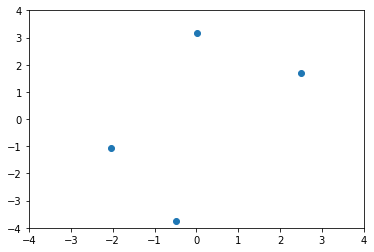

In [116]:
import matplotlib.pyplot as plt
plt.scatter(df_new['X'],df_new['Y'])
plt.xlim(-4,4)
plt.ylim(-4,4)